In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import io
import itertools


import torch
import torch.nn as nn
import torch.nn.functional as F

import warnings
warnings.filterwarnings('ignore')

# <center>Deep Generative Models</center>
## <center>Seminar 1</center>

<center>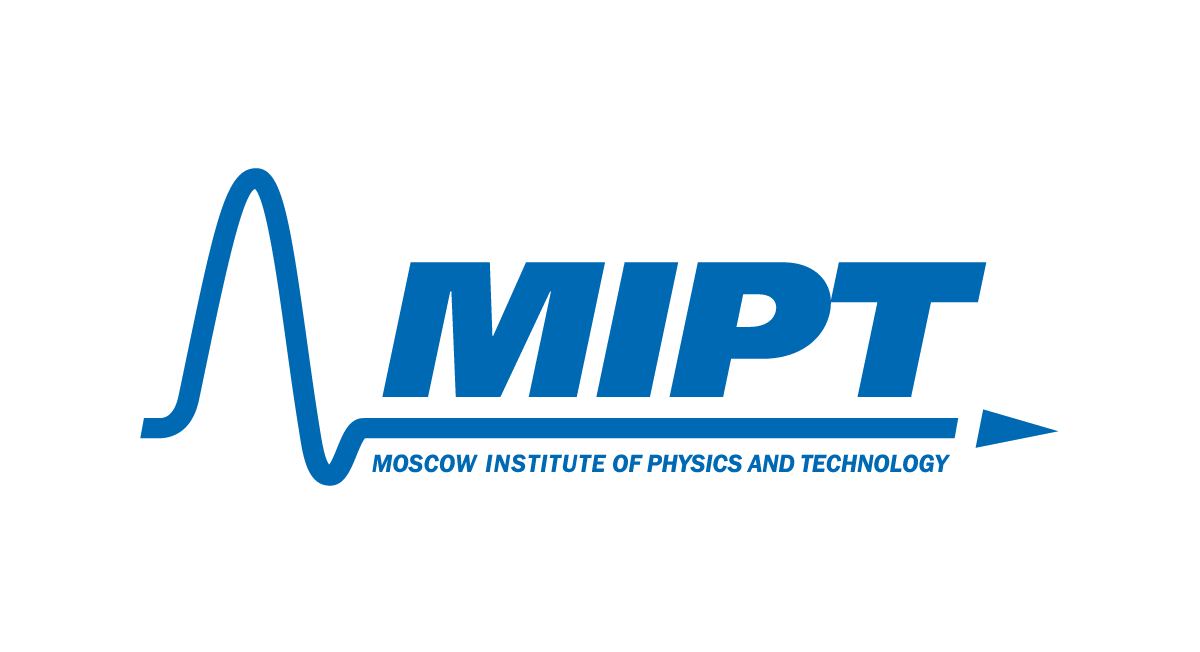</center>
<center>05.09.2023</center>


### Petr Mokrov


tg: https://t.me/PVMokrov

e-mail: mokrov.pv@phystech.edu

### Daniil Shlenskii

tg: https://t.me/daniil_shlenskii

## Plan

- Maximum Likelihood Estimation
- Histograms
- Example of a simple 1D/2D distribution
- Kernel Density Estimators

## Maximum Likelihood Estimation (MLE)

Recall the general task of Generative Modeling. 

We have samples $X \sim \pi(x)$. We assume, that $\pi(x) = p(x|\theta), \theta \in \Theta$.

We want to estimate $\hat{\theta} = \hat{\theta}(X)$ in order to sample from $p(x|\hat{\theta})$ and estimate the corresponding pdf. 

How?

$\theta^* = \arg\max\limits_{\theta} p(X | \theta) = \arg\max\limits_{\theta} \prod_{i=1}^n p(x_i | \theta) = \arg\max\limits_{\theta} \sum_{i=1}^n \log p(x_i | \theta)$

## MLE examlpes

### Problem 1

$x_1, ... x_n \sim U[0,\theta]$. 

$\hat{\theta}_{ML} = ?$

For a single $x \sim U[0,\theta]$:

$p(x) = \dfrac{1}{\theta}, x \in [0,\theta]$

$p(x) = 0, x \notin [0,\theta]$

We have $x_1, \dots x_n \sim U[0,\theta]$:

$p(X | \theta) = \begin{cases} \dfrac{1}{\theta^{n}}, &X \in [0,\theta]^{n}, \\ 0, &X \notin [0,\theta]^{n} \end{cases}$

It also can be written as:

$p(X | \theta) = \begin{cases} 0, &\theta < \max(x_1, \dots x_n), \\
\dfrac{1}{\theta^{n}}, &\theta \geq \max(x_1, \dots x_n) \end{cases}$

So, we can find:

$\hat{\theta}_{ML} = \max(x_1, ... x_n)$

$\hat{\theta}_{ML} = \max(x_1, ... x_n)$ is also random variable

How does Cumulative distribution function $F_{\hat{\theta}_{ML}}(x) = P(\hat{\theta}_{ML} < x )$ looks like?


$P_{X \sim U[0,\theta]}(\max(x_1, ... x_n) < x) = \dfrac{x^n}{\theta^n}$, $x \in [0,\theta]$

Check if the $\hat{\theta}_{ML}$ is **unbiased** estimation of $\theta$, i.e. $\mathbb{E}\hat{\theta}_{ML} = \theta$.

Let's find this $\mathbb{E}\hat{\theta}_{ML} = ?$

We know that:

$\mathbb{E}_{X \sim U[0, \theta]} \hat{\theta}_{ML} = \mathbb{E}_{\hat{\theta}_{ML}} x$

$\mathbb{E}_{X \sim U[0,\theta]}\hat{\theta}_{ML} =
\int_{0}^{\theta} x d \dfrac{x^n}{\theta^n} = ...
%\int_{0}^{\theta} \dfrac{xnx^{n-1}}{\theta^n} d x =
%\int_{0}^{\theta} \dfrac{nx^{n}}{\theta^n} d x =
%\dfrac{n\theta^{n+1}}{(n+1)\theta^n}$

$\Rightarrow \mathbb{E}_{X \sim U[0,\theta]}\hat{\theta}_{ML} = \dfrac{n}{n+1}\theta \Rightarrow$ MLE is **biased**

### MLE

- not unbiased
- *(regularity conditions)* consistent (состоятельные) i.e. $P_{\theta_{\text{true}}}( \Vert \hat{\theta} - \theta_{\text{true}} \Vert > \varepsilon ) \rightarrow 0 \quad \forall \varepsilon > 0$
- *(regularity conditions ++)* asymptotically normal (асимптотически нормальные) i.e $\sqrt{n} \left(\hat{\theta} - \theta \right) \overset{d_{\theta}}{\rightarrow} \mathcal{N}(0, \Sigma(\theta))$
- *(regularity conditions ++)* asymptotically efficient (асимптотически эффективные) i.e. $\sqrt{n} \left(\hat{\theta} - \theta \right) \overset{d_{\theta}}{\rightarrow} \mathcal{N}(0, I(\theta)) \text{  ,where } I(\theta) \text{ is Fisher matrix}$

## MLE and histogram

Let $X_1, X_2, \dots X_n \sim \text{Categorical}(\theta_1, \theta_2, \dots \theta_K)$ , where $\sum\limits_{i = 1}^{K} \theta_i = 1$

**Question.** Can we consider binarized MNIST to be sampled from a Categorical distribution?

<!-- <center><img src="data:image/png;base64," width=500 /></center> -->
<center>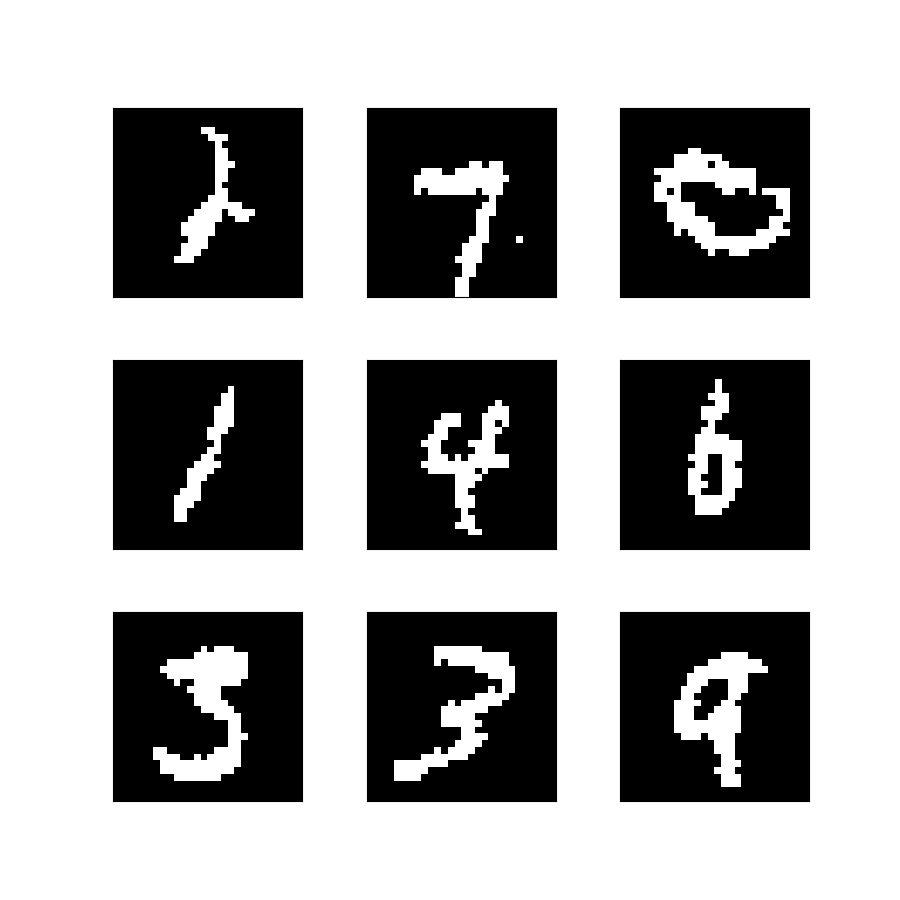</center>

## MLE and histogram

Let $X_1, X_2, \dots X_n \sim \text{Categorical}(\theta_1, \theta_2, \dots \theta_K)$ , where $\sum\limits_{i = 1}^{K} \theta_i = 1$. Denote $\boldsymbol{\theta} = (\theta_1, \dots, \theta_K)$

**Problem 2**: Find the MLE estimator $\hat{\boldsymbol{\theta}}$

### Histogram

$\hat{\theta_k} = \frac{1}{n} \sum\limits_{i = 1}^{n} I(X_i = k)$

**Question.** What the problem with histogram model for approximating binarized MNIST (or arbitrary images dataset)?

## Histograms practice 

### Histogram in 1D

In [30]:
def generate_1d_data(count, bins):
    np.random.seed(42)
    a = 0.2 + 0.05 * np.random.randn(count)
    b = 0.6 + 0.15 * np.random.randn(count)
    mask = np.random.rand(count) < 0.5
    samples = np.clip((a * mask + b * (1 - mask)) * (bins - 1), 0.0, (bins - 1))
    data = samples.astype('int')
    split = int(0.8 * count)
    train_samples, test_samples = samples[:split], samples[split:]
    train_hist, test_hist = data[:split], data[split:]
    return train_samples, test_samples, train_hist, test_hist

In [32]:
def plot_1d_data(train_data, test_data):
    bins = int(max(test_data.max(), train_data.max()) - min(test_data.min(), train_data.min())) + 1
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    ax1.set_title('train')
    ax1.hist(train_data, bins=bins, density=True)
    ax1.set_xlabel('x')
    ax2.set_title('test')
    ax2.hist(test_data, bins=np.arange(bins), density=True)
    plt.show()

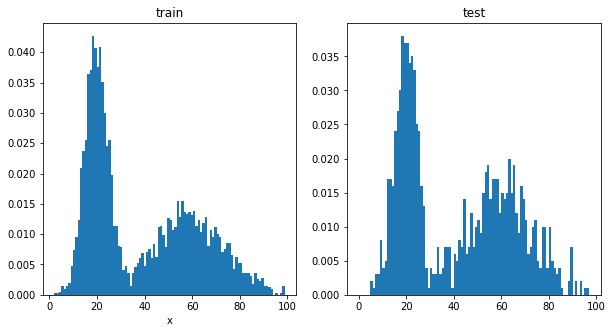

In [33]:
BINS = 100
COUNT = 5000

_, _, train_data, test_data = generate_1d_data(COUNT, BINS)
plot_1d_data(train_data, test_data)

### Histogram in 2D

In [34]:
def generate_2d_data(count, bins):
    h_bins = int(bins)
    w_bins = int(bins)
    im = Image.open('pics/2d_distribution.png').resize((w_bins, h_bins)).convert('L')
    im = np.array(im).astype('float32')
    dist = im / im.sum() # w_bins * h_bins = number of bins

    pairs = list(itertools.product(range(h_bins), range(w_bins)))
    idxs = np.random.choice(len(pairs), size=count, replace=True, p=dist.reshape(-1))
    samples = np.array([pairs[i] for i in idxs])

    split = int(0.8 * len(samples))
    return dist, samples[:split], samples[split:]

In [35]:
def plot_2d_data(train_data, test_data, bins):
    h_bins = int(bins)
    w_bins = int(bins)
    train_dist, test_dist = np.zeros((h_bins, w_bins)), np.zeros((h_bins, w_bins))
    for i in range(len(train_data)):
        train_dist[train_data[i][0], train_data[i][1]] += 1
    train_dist /= train_dist.sum()

    for i in range(len(test_data)):
        test_dist[test_data[i][0], test_data[i][1]] += 1
    test_dist /= test_dist.sum()

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6))
    ax1.set_title('Train Data')
    ax1.imshow(train_dist, cmap='gray')
    ax1.axis('off')
    ax1.set_xlabel('x1')
    ax1.set_ylabel('x0')

    ax2.set_title('Test Data')
    ax2.imshow(test_dist, cmap='gray')
    ax2.axis('off')
    ax2.set_xlabel('x1')
    ax2.set_ylabel('x0')

    plt.show()

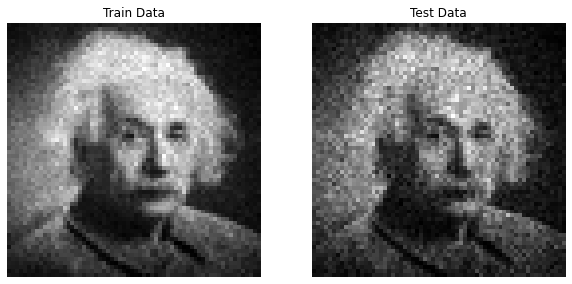

In [42]:
COUNT = 500000
BINS = 64

image, train_data, test_data = generate_2d_data(COUNT, BINS)
plot_2d_data(train_data, test_data, BINS)

## Nonparametric Statistics. Kernel Density Estimators

Let $X_1, \dots X_n \sim \pi$, $\pi \in \mathcal{P}_{ac}(\mathbb{R}^d)$. No parametric assumptions on $\pi$! 

The task is to come up with $\hat{p}(x)$ which estimates the probability density function (pdf) of $\pi$


### KDE

*  $K(x), x \in \mathbb{R}^d$  - "basic" probability density function. Practically we assume $K(x)$ is symmetric. 

*  $h > 0$ is the kernel width (scaling parameter)

$$
\hat{p}_h(x) = \frac{1}{n h^d} \sum\limits_{i = 1}^n K\left(\frac{x - X_i}{h}\right)
$$

<center>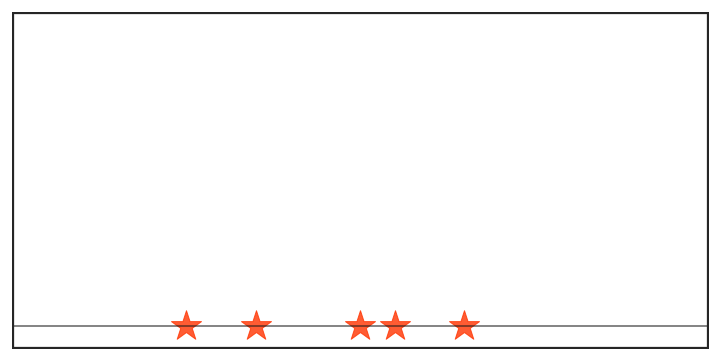</center>
<!-- <center><img src="pics/kde_points.png" width=800 /></center> -->

<center>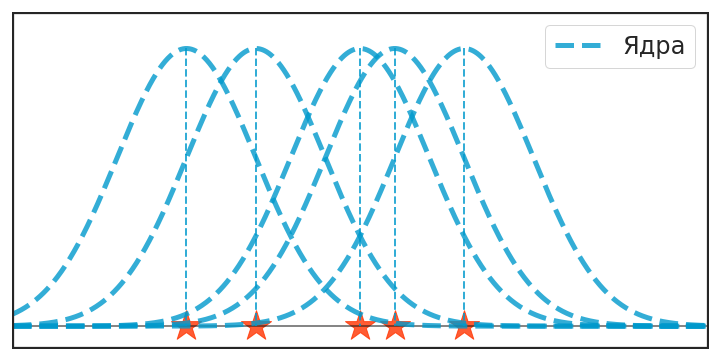</center>
<!-- <center><img src="pics/kde_points_and_kernels.png" width=800 /></center> -->

<center>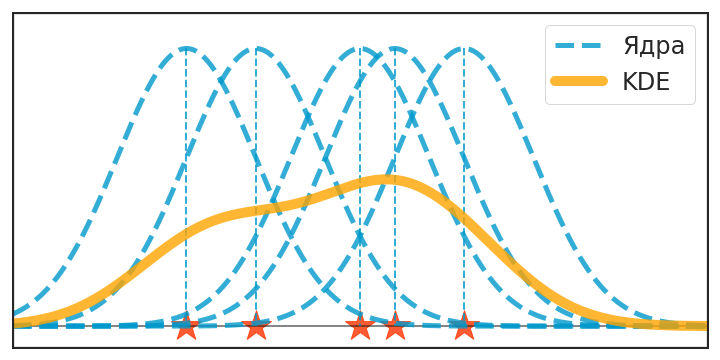</center>
<!-- <center><img src="pics/kde_full.png" width=800 /></center> -->


### Kernel examples in 1D

<center>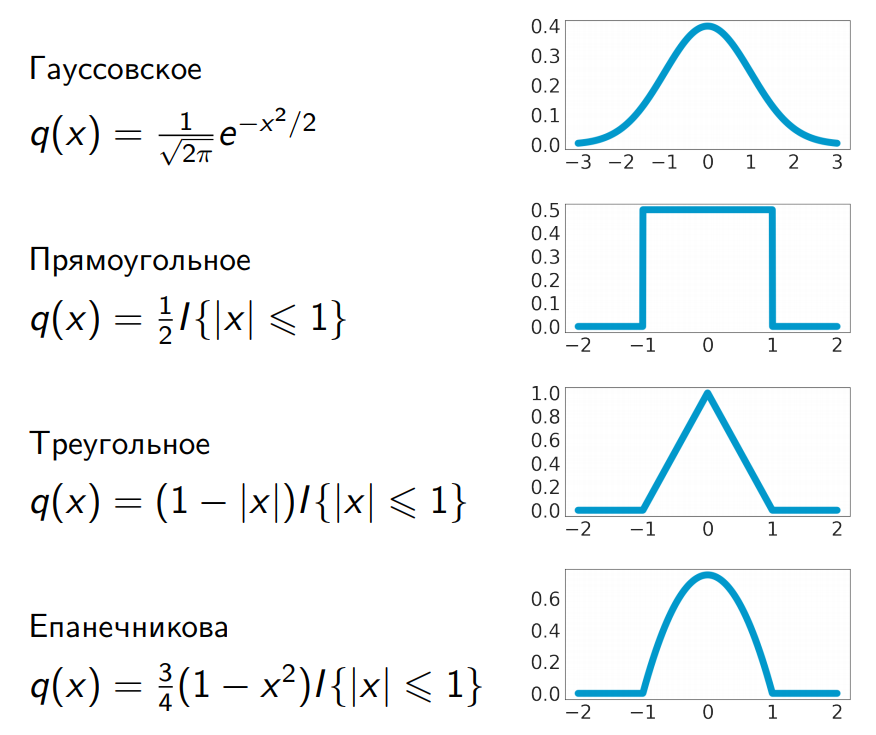</center>
<!-- <center><img src="pics/kernel_types.png" width=875 /></center> -->

<sub>*images credits: MS course at MIPT by N. Volkov, 2019*</sub>

### KDE theory links

* Asymptotical properties of KDE in 1D : [link](https://bayes.wustl.edu/Manual/parzen62.pdf)

* Asymptotical properties of KDE in high dimensions: [link](https://www.ism.ac.jp/editsec/aism/pdf/018_2_0179.pdf) (there are misprints in the article!)

* Lectures by L. Wasserman [youtube](https://www.youtube.com/playlist?list=PLjbUi5mgii6BWEUZf7He6nowWvGne_Y8r) ($MSE$ risk analysis covered)

* Bandwidth selection methods blog post [link](https://aakinshin.net/posts/kde-bw/)

### KDE practice

In [10]:
import scipy.stats as sps
from tqdm import tqdm_notebook
import pandas as pd
from statsmodels.nonparametric.kde import kernel_switch, KDEUnivariate
from statsmodels.nonparametric.kernel_density import KDEMultivariate

## KDE practice

### KDE in 1D 

$\widehat{p}_{n}(x) = \frac{1}{n h} \sum\limits_{i = 1}^{n} K\left(\frac{x - X_i}{h}\right)$

We will use the [statsmodels](https://www.statsmodels.org/dev/index.html) library

Types of 1D kernels in `statsmodels`:

In [43]:
from statsmodels.nonparametric.kde import kernel_switch, KDEUnivariate
list(kernel_switch.keys())

['gau', 'epa', 'uni', 'tri', 'biw', 'triw', 'cos', 'cos2']

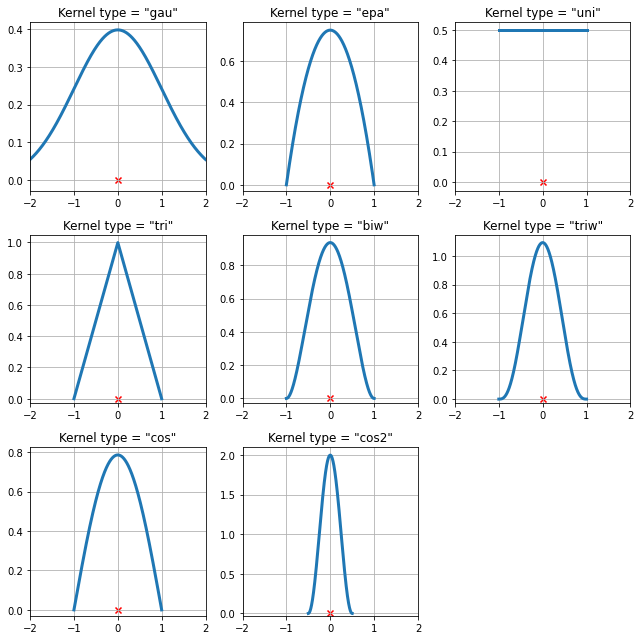

In [44]:
fig = plt.figure(figsize=(9, 9))

for i, (ker_name, ker_class) in enumerate(kernel_switch.items()):
    
    kernel = ker_class()  # kernel
    domain = kernel.domain or [-2, 2]  # kernel support
    x_vals = np.linspace(*domain, 2**10)
    y_vals = kernel(x_vals)

    ax = fig.add_subplot(3, 3, i + 1)
    ax.set_title('Kernel type = "{}"'.format(ker_name))
    ax.plot(x_vals, y_vals, lw=3, label='{}'.format(ker_name))
    ax.scatter([0], [0], marker='x', color='red')
    plt.grid(True, zorder=-5)
    ax.set_xlim((-2, 2))
    ax.set_ylim(-0.03)
    
plt.tight_layout()

## KDE practice

### KDE in 1D 

Recall the 1D example distribution:

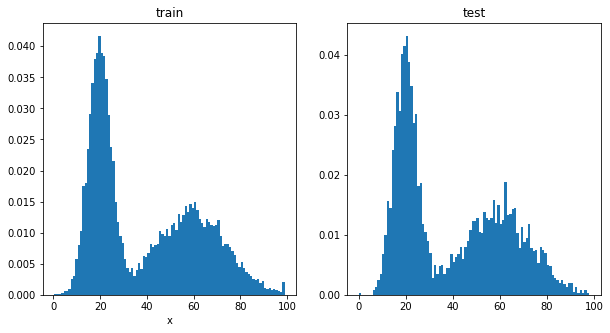

In [45]:
COUNT = 20000
BINS = 100
train_data, test_data, _, _ = generate_1d_data(COUNT, BINS)
plot_1d_data(train_data, test_data)

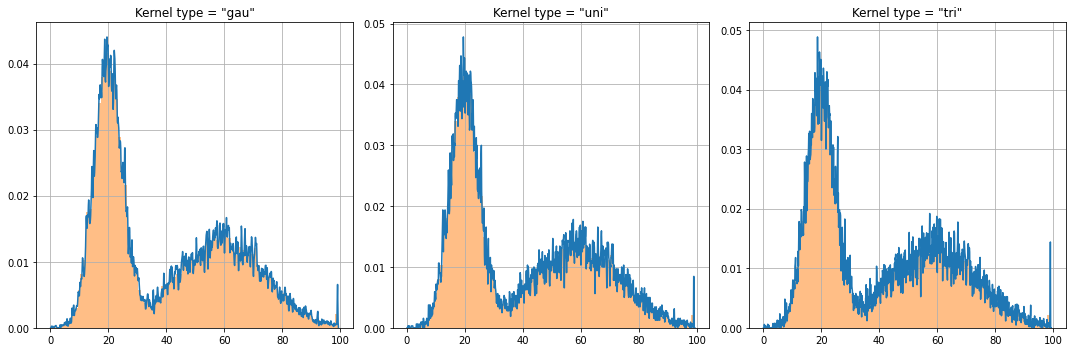

In [47]:
kde = KDEUnivariate(train_data)  # объект, выполняющий построение оценки

num_bins = int(train_data.max() - train_data.min()) + 1 # для построения гистограммы

fig = plt.figure(figsize=(15, 5))
kernel_types = ['gau', 'uni', 'tri']

for i, kernel in enumerate(kernel_types):
    
    ax = fig.add_subplot(1, 3, i + 1)
    ax.set_title('Kernel type = "{}"'.format(kernel))
    
    # построение ядерной оценки плотности с заданным ядром
    # bw is "scott", "silverman", ... 
    kde.fit(kernel=kernel, bw=0.1, fft=False, gridsize=2**10)
    ax.plot(kde.support, kde.density)
    # отрисовка гистограммы
    ax.hist(train_data, bins=num_bins, density=True, alpha=0.5)
    plt.grid(True)
    
plt.tight_layout()

## KDE practice

### KDE in 2D

Recall the 2D example distribution:

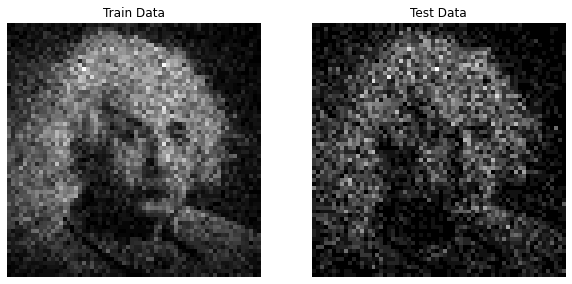

In [48]:
COUNT = 50000
BINS = 64

image, train_data, test_data = generate_2d_data(COUNT, BINS)
plot_2d_data(train_data, test_data, BINS)

In [49]:
def plot_kde_pdf(kde_model, bins, dx=0.5, dy=0.5):
    h_bins = int(bins)
    w_bins = int(bins)
    x_lim = (0, w_bins)
    y_lim = (0, h_bins)
    y, x = np.mgrid[slice(y_lim[0], y_lim[1] + dy, dy),
                    slice(x_lim[0], x_lim[1] + dx, dx)]
    mesh_xs = np.stack([y, x], axis=2).reshape(-1, 2)
    if isinstance(kde_model, KDEMultivariate):
        densities = kde_model.pdf(mesh_xs).reshape(y.shape)[::-1]
    else:
        densities = kde_model.pdf(mesh_xs.T).reshape(y.shape)[::-1]
#     print(densities.shape)
    plt.figure(figsize=(5, 5))
    plt.pcolormesh(x, y, densities, shading='nearest')
    plt.show()

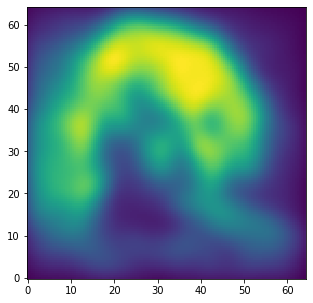

In [17]:
# KDEMultivariate uses gaussian kernel for continuous data 
from statsmodels.nonparametric.kernel_density import KDEMultivariate
from statsmodels.nonparametric.kernel_density import EstimatorSettings
from scipy.stats import gaussian_kde

sm_settings = EstimatorSettings(efficient=True)
kde_model = KDEMultivariate(data=train_data, var_type='cc', bw='cv_ls', defaults=sm_settings)
# kde_model = gaussian_kde(train_data.T, bw_method=0.1)

plot_kde_pdf(kde_model, BINS, dx=0.5, dy=0.5)

Let's see the `IMSE` rate under different values of bandwidth

Bandwidth range: 
min: (1.0, 1.0)
max: (8.166, 10.185)


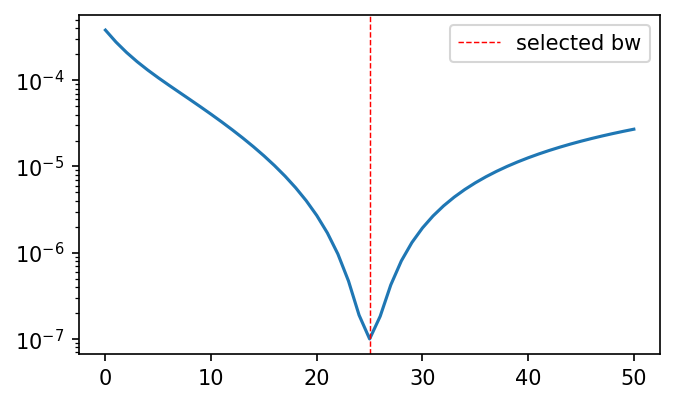

In [50]:
plt.figure(figsize=(5, 3), dpi=150)
sm_settings = EstimatorSettings(efficient=False)
kde_model = KDEMultivariate(data=train_data[:200], var_type='cc', bw='cv_ls', defaults=sm_settings)

x_bw = np.linspace(-kde_model.bw[0]+1., kde_model.bw[0] - 1., 51)
y_bw = np.linspace(-kde_model.bw[1]+1., kde_model.bw[1] - 1., 51)

print('Bandwidth range: \n',
    'min: ({}, {})\n'.format(kde_model.bw[0]+x_bw[0], kde_model.bw[1]+y_bw[0]) , 
    'max: ({}, {})'.format(round(kde_model.bw[0]+x_bw[-1], 3), round(kde_model.bw[1]+y_bw[-1], 3)), 
    sep='')

imses = []
bw_range = kde_model.bw + np.stack([x_bw, y_bw], axis=-1)
for bw in kde_model.bw + np.stack([x_bw, y_bw], axis=-1):
    imses.append(kde_model.imse(bw))
imses = np.asarray(imses)
imses -= (imses.min() - 1e-7)
plt.semilogy(imses)
plt.axvline(25, ls='--', lw=0.7, color='red', label='selected bw')
plt.legend()
plt.show()